# Code examples

Here are examples of code used in the estimation of the *carbon footprint* of the LCA XVII conference. The final paper can be found [here](https://doi.org/10.1007/s11367-018-1479-z) or [here](https://link.springer.com/article/10.1007%2Fs11367-018-1479-z). The pre-print version [here](https://engrxiv.org/g4qz5/).

**Import statements**

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from geopy import distance
from geopy import Point
import geopy.geocoders
import cartopy

from scipy.spatial.distance import cdist,euclidean

import json
import requests

In [2]:
%matplotlib inline

## Geolocate
Geocoders were used to estimate the location of participants given the address.
Several geocoders are available, in this case I use the one provided by Google.

In [3]:
gg= geopy.geocoders.GoogleV3()

The geolocation algorithm does a good job even with poorly described address, as far as they
are unequivocal. It works much better when an API key is used, but for demonstration purposes
it is not necessary. We test it with 3 different universities.

In [4]:
Udes_address='Universite de Sherbrooke, Sherbrooke'
UOxford_address='Oxford University, UK'
U_campinas=('Universidade Estadual de Campinas')
conference_address=('Portsmouth, NH 03801, USA')

In [5]:
conference_loc=gg.geocode(conference_address)

In [6]:
Udes_loc=gg.geocode(Udes_address)

In [7]:
UOxford_loc=gg.geocode(UOxford_address)

In [8]:
Ucampinas_loc=gg.geocode(U_campinas)

In [9]:
print(conference_loc)
print(Udes_loc)
print(UOxford_loc)
print(Ucampinas_loc)

Portsmouth, NH 03801, USA
Administration, 2500 Boulevard de l'Université, Sherbrooke, QC J1K 2R1, Canada
Oxford OX1 2JD, UK
Cidade Universitária Zeferino Vaz - Barão Geraldo, Campinas - SP, 13083-970, Brazil


## calculate *as the crow flies* distance

Distances are used to estimate the footprint of travelling. The distance between two points is calculated as the geodesic distance using the Vicenty formula

In [11]:
distance.distance((conference_loc.latitude,conference_loc.longitude),
                  (Udes_loc.latitude,Udes_loc.longitude)).kilometers

272.4397133919147

## Calculate distance by road

Distances travelled are always larger than the geodesic distance between two points. There's rarely a straight road from the point of departure to destination. We can do a better job estimating travelled distances using services such as the API of Google maps. The use of API can be easily extended to hundreds of participants. 

In [12]:
base_url='https://maps.googleapis.com/maps/api/distancematrix/json?'

In [13]:
req={'origins':'Universite de Sherbrooke, Sherbrooke',
'destinations':'Portsmouth, NH 03801, USA',
'mode': 'driving'}

In [14]:
r =requests.get(base_url,params=req)

In [15]:
x = json.loads(r.text)

In [16]:
x

{'destination_addresses': ['Portsmouth, NH 03801, USA'],
 'origin_addresses': ["Administration, 2500 Boulevard de l'Université, Sherbrooke, QC J1K 2R1, Canada"],
 'rows': [{'elements': [{'distance': {'text': '394 km', 'value': 394170},
     'duration': {'text': '3 hours 56 mins', 'value': 14138},
     'status': 'OK'}]}],
 'status': 'OK'}

With the right indexing we can get to the information we are interested in

In [17]:
x['rows'][0]['elements'][0]['distance']['text']

'394 km'

## calculating the optimal location

The location wich minimises the distance to all the participants is the geometric median. We use a vectorized version of the algorithm proposed by Vardi and Zhang [(2000)](http://www.pnas.org/content/97/4/1423). This function was written by [Orson
Peters](https://stackoverflow.com/questions/30299267/geometric-median-of-multidimensional-points).

In [18]:
def geometric_median(X, eps=1e-6):
    y = np.mean(X, 0)
    while True:
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]
        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)
        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y
        if euclidean(y, y1) < eps:
            return y1
        y = y1


We test the algorithm with the 3 Universities that were previously geolocated 

In [20]:
origins=np.array([(Udes_loc.latitude,Udes_loc.longitude),
                  (UOxford_loc.latitude,UOxford_loc.longitude),
                  (Ucampinas_loc.latitude,Ucampinas_loc.longitude)])

In [21]:
ideal_location=geometric_median(origins,eps=1e-8)
ideal_location

array([ 28.55299121, -45.14639497])

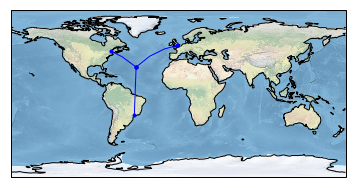

In [24]:
ax = plt.axes(projection=cartopy.crs.PlateCarree())

ax.coastlines()
ax.stock_img()

plt.plot([ideal_location[1], Udes_loc.longitude],
         [ideal_location[0], Udes_loc.latitude],
         color='blue', linewidth=1, marker='.',
         transform=cartopy.crs.Geodetic(),
         )

plt.plot([ideal_location[1], UOxford_loc.longitude],
         [ideal_location[0], UOxford_loc.latitude],
         color='blue', linewidth=1, marker='.',
         transform=cartopy.crs.Geodetic(),
         )

plt.plot([ideal_location[1], Ucampinas_loc.longitude],
         [ideal_location[0], Ucampinas_loc.latitude],
         color='blue', linewidth=1, marker='.',
         transform=cartopy.crs.Geodetic(),
         );

or in a more funky projection...

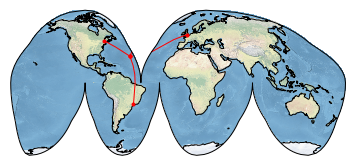

In [25]:
ax = plt.axes(projection=cartopy.crs.InterruptedGoodeHomolosine())

ax.coastlines()
ax.stock_img()

plt.plot([ideal_location[1], Udes_loc.longitude],
         [ideal_location[0], Udes_loc.latitude],
         color='red', linewidth=1, marker='.',
         transform=cartopy.crs.Geodetic(),
         )

plt.plot([ideal_location[1], UOxford_loc.longitude],
         [ideal_location[0], UOxford_loc.latitude],
         color='red', linewidth=1, marker='.',
         transform=cartopy.crs.Geodetic(),
         )

plt.plot([ideal_location[1], Ucampinas_loc.longitude],
         [ideal_location[0], Ucampinas_loc.latitude],
         color='red', linewidth=1, marker='.',
         transform=cartopy.crs.Geodetic(),
         );